In [1]:
import numpy as np
import struct

原理：
https://blog.csdn.net/luoluonuoyasuolong/article/details/90711318

整理原始矩阵$X_{n\times m} $
 
求原始矩阵$X_{n \times m}$的协防差阵$S_{m\times m}=Cov(X)$

求解协防差阵的特征值和特征向量。避免复数，用SVD奇异值分解https://blog.csdn.net/qq_24464989/article/details/79834564

选取最大的K(人为给定)个特征值所对应的特征向量组成构成矩阵$W_{m\times k}$

直接进行矩阵计算
$$
Z_{n\times k} = X_{n\times m }W_{m\times k }
$$

In [2]:
def PCA_numpy(X):
    #零均值化
    print(X.shape)
    X=X-X.mean(axis=0)
    ## 使用特征值和特征向量
    #协方差矩阵
    #cov_X = np.cov(X,rowvar=0)#每一列一个特征
    #eig_val,eig_vec = np.linalg.eig(cov_X)   #出现复数了
    ##使用svd
    U,eig_val,eig_vec = np.linalg.svd(X)
    #选两个最大的
    idx = np.argsort(-eig_val)
    temp_M=[]
    for i in range(2):
        temp_M.append(eig_vec[idx[i]])
    temp_M = np.array(temp_M).T
    result = np.dot(X,temp_M)
    return result

In [3]:
# 用手写数字mnist测试
#读取方法https://blog.csdn.net/jiede1/article/details/77099326
test_img_file = '../dataset/t10k-images-idx3-ubyte'
test_label_file = '../dataset/t10k-labels-idx1-ubyte'

def decode_idx3_ubyte(idx3_ubyte_file):
    """
    解析idx3文件的通用函数
    :param idx3_ubyte_file: idx3文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx3_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数、图片数量、每张图片高、每张图片宽
    offset = 0
    fmt_header = '>iiii' #因为数据结构中前4行的数据类型都是32位整型，所以采用i格式，但我们需要读取前4行数据，所以需要4个i。我们后面会看到标签集中，只使用2个ii。
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print('魔数:%d, 图片数量: %d张, 图片大小: %d*%d' % (magic_number, num_images, num_rows, num_cols))

    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)  #获得数据在缓存中的指针位置，从前面介绍的数据结构可以看出，读取了前4行之后，指针位置（即偏移位置offset）指向0016。
    print(offset)
    fmt_image = '>' + str(image_size) + 'B'  #图像数据像素值的类型为unsigned char型，对应的format格式为B。这里还有加上图像大小784，是为了读取784个B格式数据，如果没有则只会读取一个值（即一副图像中的一个像素值）
    print(fmt_image,offset,struct.calcsize(fmt_image))
    images = np.empty((num_images, num_rows, num_cols))
    #plt.figure()
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print('已解析 %d' % (i + 1) + '张')
            print(offset)
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        #print(images[i])
        offset += struct.calcsize(fmt_image)
#        plt.imshow(images[i],'gray')
#        plt.pause(0.00001)
#        plt.show()
    #plt.show()

    return images


def decode_idx1_ubyte(idx1_ubyte_file):
    """
    解析idx1文件的通用函数
    :param idx1_ubyte_file: idx1文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数和标签数
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print('魔数:%d, 图片数量: %d张' % (magic_number, num_images))

    # 解析数据集
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('已解析 %d' % (i + 1) + '张')
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels


def load_test_images(idx_ubyte_file=test_img_file):
    """
    TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  10000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(test_img_file)

def load_test_labels(idx_ubyte_file=test_label_file):
    """
    TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  10000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)

In [4]:
images = load_test_images()
label = load_test_labels()

images = images/255.0
data = images.reshape((-1,28*28))

result = PCA_numpy(data)
print(result.shape)

魔数:2051, 图片数量: 10000张, 图片大小: 28*28
16
>784B 16 784
已解析 10000张
7839232
魔数:2049, 图片数量: 10000张
已解析 10000张
(10000, 784)
(10000, 2)


In [5]:
import matplotlib.pyplot as plt

In [6]:
## 与sklearn对应
result[:,0]= -1*result[:,0]

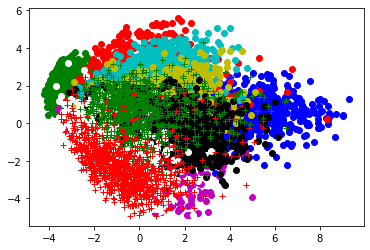

In [7]:
find0 = (label==0)
plt.plot(result[find0,0],result[find0,1],'ob')
find1 = (label==1)
plt.plot(result[find1,0],result[find1,1],'og')
find2 = (label==2)
plt.plot(result[find2,0],result[find2,1],'or')
find3 = (label==3)
plt.plot(result[find3,0],result[find3,1],'oc')
find4 = (label==4)
plt.plot(result[find4,0],result[find4,1],'om')
find5 = (label==5)
plt.plot(result[find5,0],result[find5,1],'oy')
find6 = (label==6)
plt.plot(result[find6,0],result[find6,1],'ok')
find7 = (label==7)
plt.plot(result[find7,0],result[find7,1],'ow')
find8 = (label==8)
plt.plot(result[find8,0],result[find8,1],'+g')
find9 = (label==9)
plt.plot(result[find9,0],result[find9,1],'+r')

## 特征值求解

In [8]:
C=np.array([[1,1],[-1,1]])

In [9]:
eigen_vals, eigen_vecs = np.linalg.eig(C)

In [10]:
print(eigen_vals, eigen_vecs)

[1.+1.j 1.-1.j] [[0.70710678+0.j         0.70710678-0.j        ]
 [0.        +0.70710678j 0.        -0.70710678j]]


In [11]:
np.linalg.svd(C)

(array([[-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678]]),
 array([1.41421356, 1.41421356]),
 array([[-1., -0.],
        [ 0.,  1.]]))

## pca与svd

In [12]:
a=np.array([[1,5,7],[2,3,6]])
C = np.dot(a.T, a)

In [13]:
a

array([[1, 5, 7],
       [2, 3, 6]])

In [14]:
eigen_vals,eigen_vecs = np.linalg.eig(C)
u,sigma,v=np.linalg.svd(a,full_matrices=False,compute_uv=True)

In [15]:
print(eigen_vals,sigma**2)

[1.22415230e+02 1.58477013e+00 1.18188483e-15] [122.41522987   1.58477013]


In [16]:
eigen_vecs

array([[-0.1836866 , -0.74076546, -0.64616234],
       [-0.52210838,  0.63048071, -0.57436653],
       [-0.83286378, -0.23186334,  0.50257071]])

In [17]:
v.T

array([[-0.1836866 ,  0.74076546],
       [-0.52210838, -0.63048071],
       [-0.83286378,  0.23186334]])

## 问题
在直接使用eig而不是svd计算特征值和特征向量的时候，为什么会出现复数的情况？

按理说$XX^T$得到的是实对称矩阵，而实对称矩阵的特征值和特征向量是实数，但是代码求得的是复数，如下：

In [18]:
data.shape

(10000, 784)

In [19]:
cov_X = np.cov(data,rowvar=0)#每一列一个特征
eig_val1,eig_vec1 = np.linalg.eig(cov_X)   #出现复数了

In [20]:
np.max(eig_val1)

(5.31054515640219+0j)

In [21]:
# 使用svd一切正常
U,eig_val2,eig_vec2 = np.linalg.svd(data,full_matrices=False,compute_uv=True)

In [22]:
np.max(eig_val2)

629.6279685247381

## sklearn中的PCA

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA(n_components=2)
result = pca.fit_transform(data)

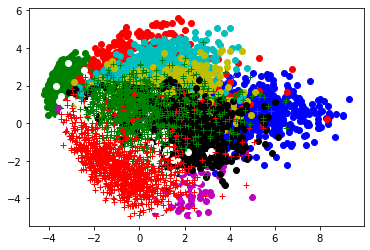

In [25]:
find0 = (label==0)
plt.plot(result[find0,0],result[find0,1],'ob')
find1 = (label==1)
plt.plot(result[find1,0],result[find1,1],'og')
find2 = (label==2)
plt.plot(result[find2,0],result[find2,1],'or')
find3 = (label==3)
plt.plot(result[find3,0],result[find3,1],'oc')
find4 = (label==4)
plt.plot(result[find4,0],result[find4,1],'om')
find5 = (label==5)
plt.plot(result[find5,0],result[find5,1],'oy')
find6 = (label==6)
plt.plot(result[find6,0],result[find6,1],'ok')
find7 = (label==7)
plt.plot(result[find7,0],result[find7,1],'ow')
find8 = (label==8)
plt.plot(result[find8,0],result[find8,1],'+g')
find9 = (label==9)
plt.plot(result[find9,0],result[find9,1],'+r')